In [24]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib

warnings.filterwarnings("ignore", category=FutureWarning)

In [25]:
# Load configuration and data
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()
df.dtypes

timestamp             datetime64[ns, UTC]
message                            object
author                             object
has_emoji                            bool
is_topk                              bool
message_length                      int64
has_link                             bool
timestamp_category               category
hour                               object
day_of_week                         int32
msg_length                          int64
dtype: object

# Example User Stories & Correlations

In [26]:
print(df.dtypes)


timestamp             datetime64[ns, UTC]
message                            object
author                             object
has_emoji                            bool
is_topk                              bool
message_length                      int64
has_link                             bool
timestamp_category               category
hour                               object
day_of_week                         int32
msg_length                          int64
dtype: object


In [27]:

# --- Load metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

# Convert dictionary to a DataFrame
author_info_df = pd.DataFrame(nested_users).T.reset_index().rename(columns={'index': 'author'})

# --- Merge WhatsApp data with user info ---
df_merged = df.merge(author_info_df, on='author', how='left')

# --- Aggregate per apartment unit ---
unit_stats = (
    df_merged.groupby("Unit_nr")
             .agg(total_messages=("message", "count"),
                  avg_msg_length=("msg_length", "mean"),
                  Entrance_nr=("Entrance_nr", "first"),
                  Gender=("Gender", "first"),
                  Floor_nr=("Floor_nr", "first"),
                  Nr_rooms=("Nr_rooms", "first"))
             .reset_index()
)



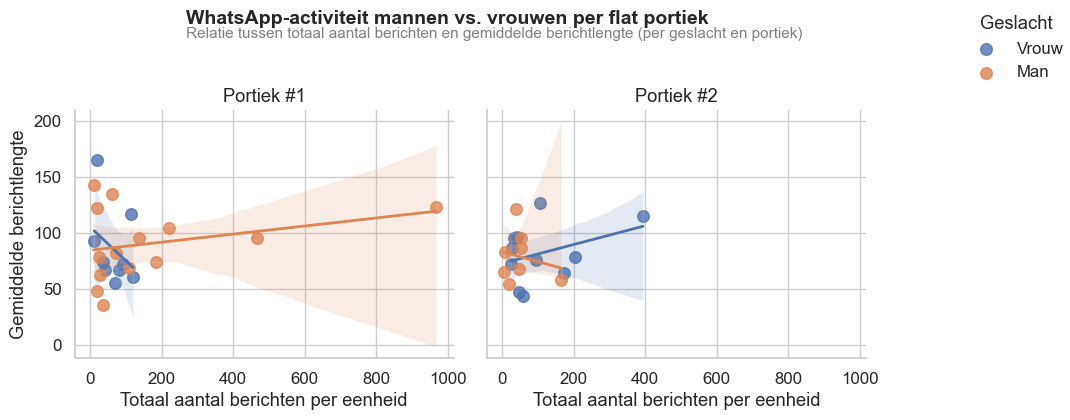

In [28]:
sns.set_theme(style="whitegrid", font_scale=1.1)

g = sns.lmplot(
    data=unit_stats,
    x="total_messages",
    y="avg_msg_length",
    hue="Gender",
    col="Entrance_nr",
    col_wrap=3,
    height=4,
    scatter_kws={"s": 70, "alpha": 0.8},
    line_kws={"lw": 2},
)

# )
# --- Update axis labels and main title ---
g.set_axis_labels("Totaal aantal berichten per eenheid", "Gemiddelde berichtlengte")
g.fig.suptitle(
    "WhatsApp-activiteit mannen vs. vrouwen per flat portiek",
    x=0.15,  # move left (0 = far left, 0.5 = center)
    y=1.05,
    fontsize=14,
    fontweight="bold",
    ha="left"  # align text to the left
)

# --- Add subtitle below main title ---
plt.figtext(
    0.15,  # move left (matching main title)
    0.98,
    "Relatie tussen totaal aantal berichten en gemiddelde berichtlengte (per geslacht en portiek)",
    ha="left",  # align text to the left
    fontsize=11,
    color="gray"
)


# --- Replace 'Entrance_nr' with 'Portiek nr' in facet titles ---
for ax in g.axes.flat:
    title = ax.get_title()
    # Replace 'Entrance_nr = X' with 'Portiek #X'
    ax.set_title(title.replace("Entrance_nr = ", "Portiek #"))

# --- Adjust legend title and position ---
if g._legend is not None:
    g._legend.set_title("Geslacht")
    # Move legend to upper left inside figure
    g._legend.set_bbox_to_anchor((0.73, 1.05))  # x=0.02 moves it more to the left
    g._legend.set_loc('upper left')

plt.tight_layout()
plt.show()


In [1]:
# %% -------------------------------------------
# Correlation: Do people who write more messages also write longer ones?
# -------------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# --- Compute Pearson correlation coefficient ---
corr_value = unit_stats['total_messages'].corr(unit_stats['avg_msg_length'])
print(f"📊 Pearson correlation between total messages and avg message length: {corr_value:.3f}")

# --- Scatterplot with regression line ---
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(7, 5))

sns.regplot(
    data=unit_stats,
    x='total_messages',
    y='avg_msg_length',
    scatter_kws={'s': 70, 'alpha': 0.8},
    line_kws={'color': 'red', 'lw': 2}
)

plt.title(
    "Do people who write more messages also write longer ones?",
    fontsize=14,
    fontweight="bold",
    pad=15
)
plt.xlabel("Total number of messages per unit")
plt.ylabel("Average message length")
plt.figtext(
    0.5, -0.05,
    f"Pearson correlation = {corr_value:.2f}",
    ha='center', fontsize=11, color='gray'
)
plt.tight_layout()
plt.show()


NameError: name 'unit_stats' is not defined